<a href="https://colab.research.google.com/github/dpkeee/EVA6/blob/main/Copy_of_S4_Assignment_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Session 4 - Backpropagation and Architectural Basics

1. Refer to this code: COLABLINK (https://colab.research.google.com/drive/1uJZvJdi5VprOQHROtJIHy0mnY2afjNlx)
2. WRITE IT AGAIN SUCH THAT IT ACHIEVES
3. 99.4% validation accuracy
4. Less than 20k Parameters
5. You can use anything from above you want. 
6. Less than 20 Epochs
7. Have used BN, Dropout, a Fully connected layer, have used GAP. 

### Achieved 99.47 accuracy  by using

1.Using less than 20,000 parameters

2.Achieved 99% accuracy within 4 epochs

3.Achieved 99.47 % accuracy at 11th epoch and with less than 20,000 parameters which means we successfully saved RAM (i.e Computation) and used correct Computer Vision Techniques for getting a good accuracy with less no of training loops.

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary 
import matplotlib.pyplot as plt
import numpy as np
import torchvision

In [3]:
# check if cuda is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device,"is being used")

cuda is being used



## Load and Prepare Dataset
MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels

We load the PIL images using torchvision.datasets.MNIST, while loading the image we transform the data to tensor and normalize the images with mean and std deviation of MNIST images.

We have a batch size of 128 and shuffle is true so that we get different set of 128 images each time.

In [4]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([transforms.RandomRotation(10),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)



Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Creating a function to Visualize the dataset using matplotlib's plot function

In [5]:
#function for visualizing dataset
def imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [6]:
classes = (0,1,2,3,4,5,6,7,8,9)

# View sample of images as a grid 

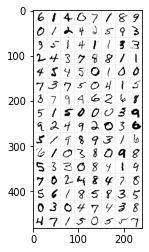

In [7]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
imshow(img_grid, one_channel=True)


# View a single  sample image

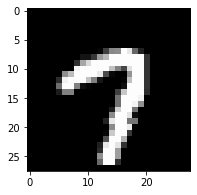

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

# Defining a Model

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
            #input-28x28x1
        self.conv1 = nn.Sequential(                          
            # RF - 3x3
            nn.Conv2d(1, 16, 3, bias=False),                    #Input: 28*28*1    Output:26 * 26 * 16    GRF:3 * 3 
            nn.ReLU(),                                           
            nn.BatchNorm2d(16),                                  
            nn.Dropout2d(0.1),                                  #Dropput layer has been used with probability of 0.1

            #input-26x26x16                                     #Input: 26*26*16    Output:24 * 24 * 16    GRF:5 * 5 
            # RF - 5x5
            nn.Conv2d(16, 16, 3, bias=False),                      
            nn.ReLU(), 
            nn.BatchNorm2d(16),          
            
            #input-24x24x16                                    #Input: 24*24*16    Output:22 * 22 * 32    GRF:7 * 7 
            # RF - 7x7
            nn.Conv2d(16, 32, 3, bias=False),            
            nn.ReLU(),         
            nn.BatchNorm2d(32),  
            nn.Dropout2d(0.1),
        )

        
        #Transition block
        self.transition= nn.Sequential(                         
            #input-22x22x32
            nn.Conv2d(32,16,1),
            nn.ReLU(),

            nn.MaxPool2d(2, 2),
            #output=11x11x16
        )      

        self.conv2 = nn.Sequential(
            
            #input=11x11x16
            nn.Conv2d(16, 16, 3, bias=False), #RF=16x16          
            nn.ReLU(),          
            nn.BatchNorm2d(16),   
            nn.Dropout2d(0.1), 

            #input=9x9x16
            nn.Conv2d(16, 16, 3, padding=1, bias=False),        
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),
            
            nn.Conv2d(16, 16, 3,bias=False),               
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),
            
            #input=7x7x16
            nn.Conv2d(16,32, 3, bias=False),    
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.1),        

        )   #output=5x5x32

        self.conv_final=nn.Conv2d(32, 10, 1, bias=False)# input: 32x5x5, output: 32x1x1 
        self.gap = nn.AvgPool2d(5)     # GAP layer        
        self.fc1 = nn.Linear(1, 1)    

    def forward(self, x):
 

        x= self.conv1(x)           

        x=self.transition(x)
        x= self.conv2(x)      
        x=self.conv_final(x)
        x=self.gap(x)
        x = self.fc1(x)
        x=x.view(-1,10)        
        
        return F.log_softmax(x)

In [10]:
# model the model to the device
model = Net().to(device)
# print the model summary when given input_size
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
         Dropout2d-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
            Conv2d-8           [-1, 32, 22, 22]           4,608
              ReLU-9           [-1, 32, 22, 22]               0
      BatchNorm2d-10           [-1, 32, 22, 22]              64
        Dropout2d-11           [-1, 32, 22, 22]               0
           Conv2d-12           [-1, 16, 22, 22]             528
             ReLU-13           [-1, 16, 22, 22]               0
        MaxPool2d-14           [-1, 16,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [11]:
from tqdm import tqdm
train_losses =[]
test_losses = []
train_acc = []
test_acc = []
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get data in batches 
        data, target = data.to(device), target.to(device)
      # initialize the gradients  
        optimizer.zero_grad()
      # Forward pass - Predict  
        output = model(data)
      # Calculate loss  
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
      # Back Propogation  
        loss.backward()
      # update weights  
        optimizer.step()
        
        
        pred =  output.argmax(dim=1, keepdim=True)  # get the index of the output
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        train_acc.append(100*correct/processed)
 

def test(model, device, test_loader):

  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))   

In [12]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


for epoch in range(1, 20):
    print('\nEpoch {} : '.format(epoch))
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 1 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9867/10000 (98.67%)


Epoch 2 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9878/10000 (98.78%)


Epoch 3 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9904/10000 (99.04%)


Epoch 4 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9912/10000 (99.12%)


Epoch 5 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9921/10000 (99.21%)


Epoch 6 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.29%)


Epoch 7 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9929/10000 (99.29%)


Epoch 8 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.35%)


Epoch 9 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)


Epoch 10 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9937/10000 (99.37%)


Epoch 11 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9934/10000 (99.34%)


Epoch 12 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9941/10000 (99.41%)


Epoch 13 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9940/10000 (99.40%)


Epoch 14 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9942/10000 (99.42%)


Epoch 15 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9943/10000 (99.43%)


Epoch 16 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9936/10000 (99.36%)


Epoch 17 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9947/10000 (99.47%)


Epoch 18 : 


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9948/10000 (99.48%)


Epoch 19 : 


loss=0.13634313642978668 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.21it/s]



Test set: Average loss: 0.0173, Accuracy: 9949/10000 (99.49%)



In [15]:
test_losses

[0.04441174680646509,
 0.03693769665658474,
 0.030909335584938528,
 0.026723466223478317,
 0.022875777437724173,
 0.02242524356916547,
 0.02116992348935455,
 0.02093165343403816,
 0.02008227998316288,
 0.01899510118602775,
 0.019850376292131842,
 0.018860288117453456,
 0.018413139379303903,
 0.017694113977148665,
 0.018954642954806332,
 0.01924943356933072,
 0.018833980654925107,
 0.01762171313950239,
 0.017311743886955083]

Text(0.5, 1.0, 'Test Accuracy')

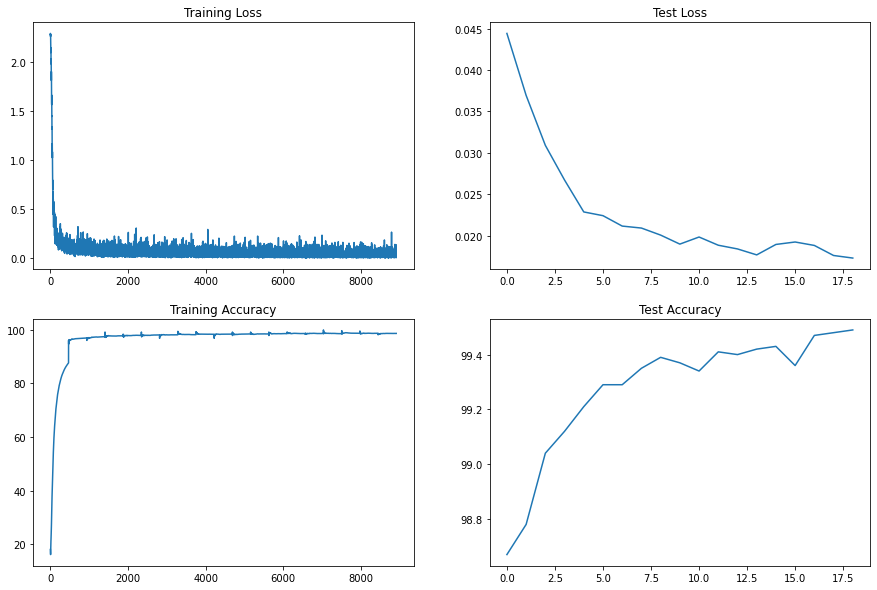

In [16]:

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")


### Achieved 99.47 accuracy  by using
1.Batchnorm

2.Drop out of 0.1(i.e 10%)

3.Using less than 20,000 parameters

4.Achieved 99% accuracy within 4 epochs

5.Achieved 99.47 % accuracy in at 11th epoch and with less than 20,000 parameters which means I successfully saved RAM (i.e Computation) and used correct Computer Vision Techniques for getting a good accuracy with less no of training loops.